In [41]:
import numpy as np
import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

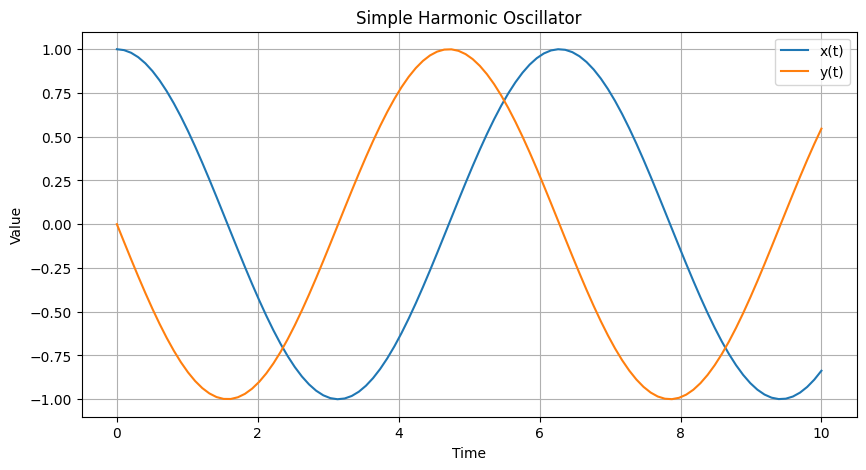

In [35]:
def parse_system(system):
    """Parse ODE system using SymPy."""
    equations = [eq.strip() for eq in system.split(',')]
    expressions = []
    
    vars = []
    for eq in equations:
        var = eq.split('/')[0].strip()[1:]
        vars.append(var)
    
    for eq in equations:
        right = eq.split('=')[1].strip()
        expressions.append(sp.sympify(right))
    
    return sp.lambdify(vars, expressions, modules='numpy')

def integrate_ode(y0, times, system, events=None, debug=False):
    """Integrate an ODE system."""
    system_fn = parse_system(system)
    
    try:
        sol = scipy.integrate.solve_ivp(
            lambda t, y: system_fn(*y),
            (min(times), max(times)),
            y0,
            t_eval=times,
            events=events
        )
        return sol.y.T
            
    except Exception as e:
        if debug:
            import traceback
            print(traceback.format_exc())
        return None

if __name__ == "__main__":
    # Example 1: Simple harmonic oscillator (2D)
    system = "dx/dt = y, dy/dt = -x"
    y0 = np.array([1.0, 0.0])
    t = np.linspace(0, 10, 100)
    
    trajectory = integrate_ode(y0, t, system, debug=True)
    
    if trajectory is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(t, trajectory[:, 0], label='x(t)')
        plt.plot(t, trajectory[:, 1], label='y(t)')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simple Harmonic Oscillator')
        plt.legend()
        plt.grid(True)
        plt.show()

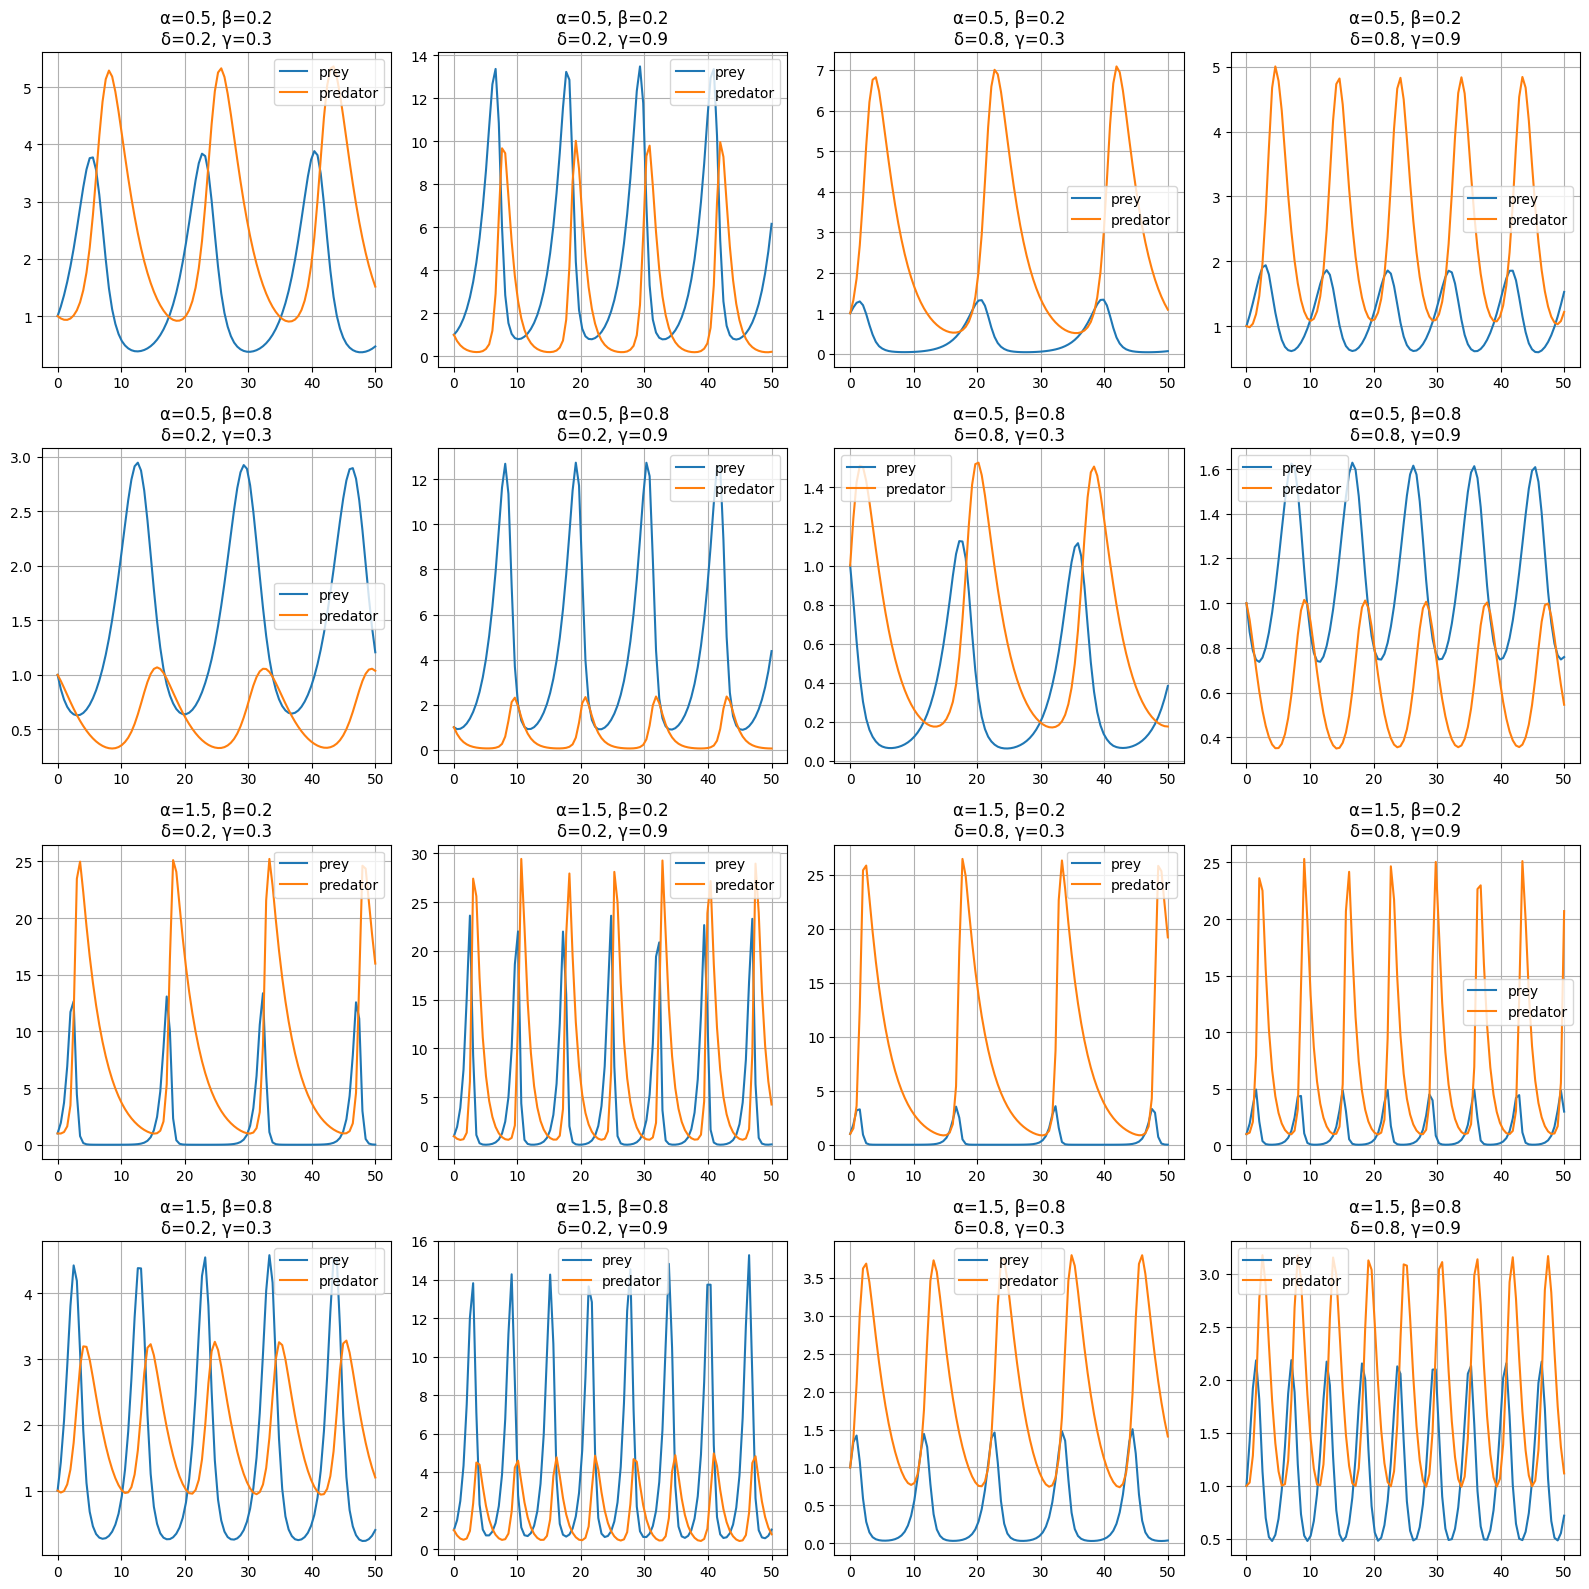

In [47]:
def solve_lv(alpha_range, beta_range, delta_range, gamma_range):
    solutions = []
    template = """dx/dt = {}*x - {}*x*y,
                  dy/dt = {}*x*y - {}*y"""
                  
    for alpha in alpha_range:
        for beta in beta_range:
            for delta in delta_range:
                for gamma in gamma_range:
                    system = template.format(alpha, beta, delta, gamma)
                    y0 = np.array([1.0, 1.0])  # initial prey and predator populations
                    t = np.linspace(0, 50, 100)
                    
                    solution = integrate_ode(y0, t, system)
                    if solution is not None:
                        solutions.append({
                            'params': (alpha, beta, delta, gamma),
                            'equations': system,
                            'solution': solution,
                            'time_points': t
                        })
    return solutions

if __name__ == "__main__":
    alpha_range = np.linspace(0.5, 1.5, 2)  # prey growth rate
    beta_range = np.linspace(0.2, 0.8, 2)   # predation rate
    delta_range = np.linspace(0.2, 0.8, 2)  # predator growth rate
    gamma_range = np.linspace(0.3, 0.9, 2)  # predator death rate
    
    solutions = solve_lv(alpha_range, beta_range, delta_range, gamma_range)
    
    with open('lotka_volterra.pkl', 'wb') as f:
        pickle.dump(solutions, f)
    
    with open('lotka_volterra.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        prey = sol['solution'][:, 0]
        predator = sol['solution'][:, 1]
        alpha, beta, delta, gamma = sol['params']
        
        axes[idx].plot(t, prey, label='prey')
        axes[idx].plot(t, predator, label='predator')
        axes[idx].set_title(f'α={alpha:.1f}, β={beta:.1f}\nδ={delta:.1f}, γ={gamma:.1f}')
        axes[idx].grid(True)
        axes[idx].legend()
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

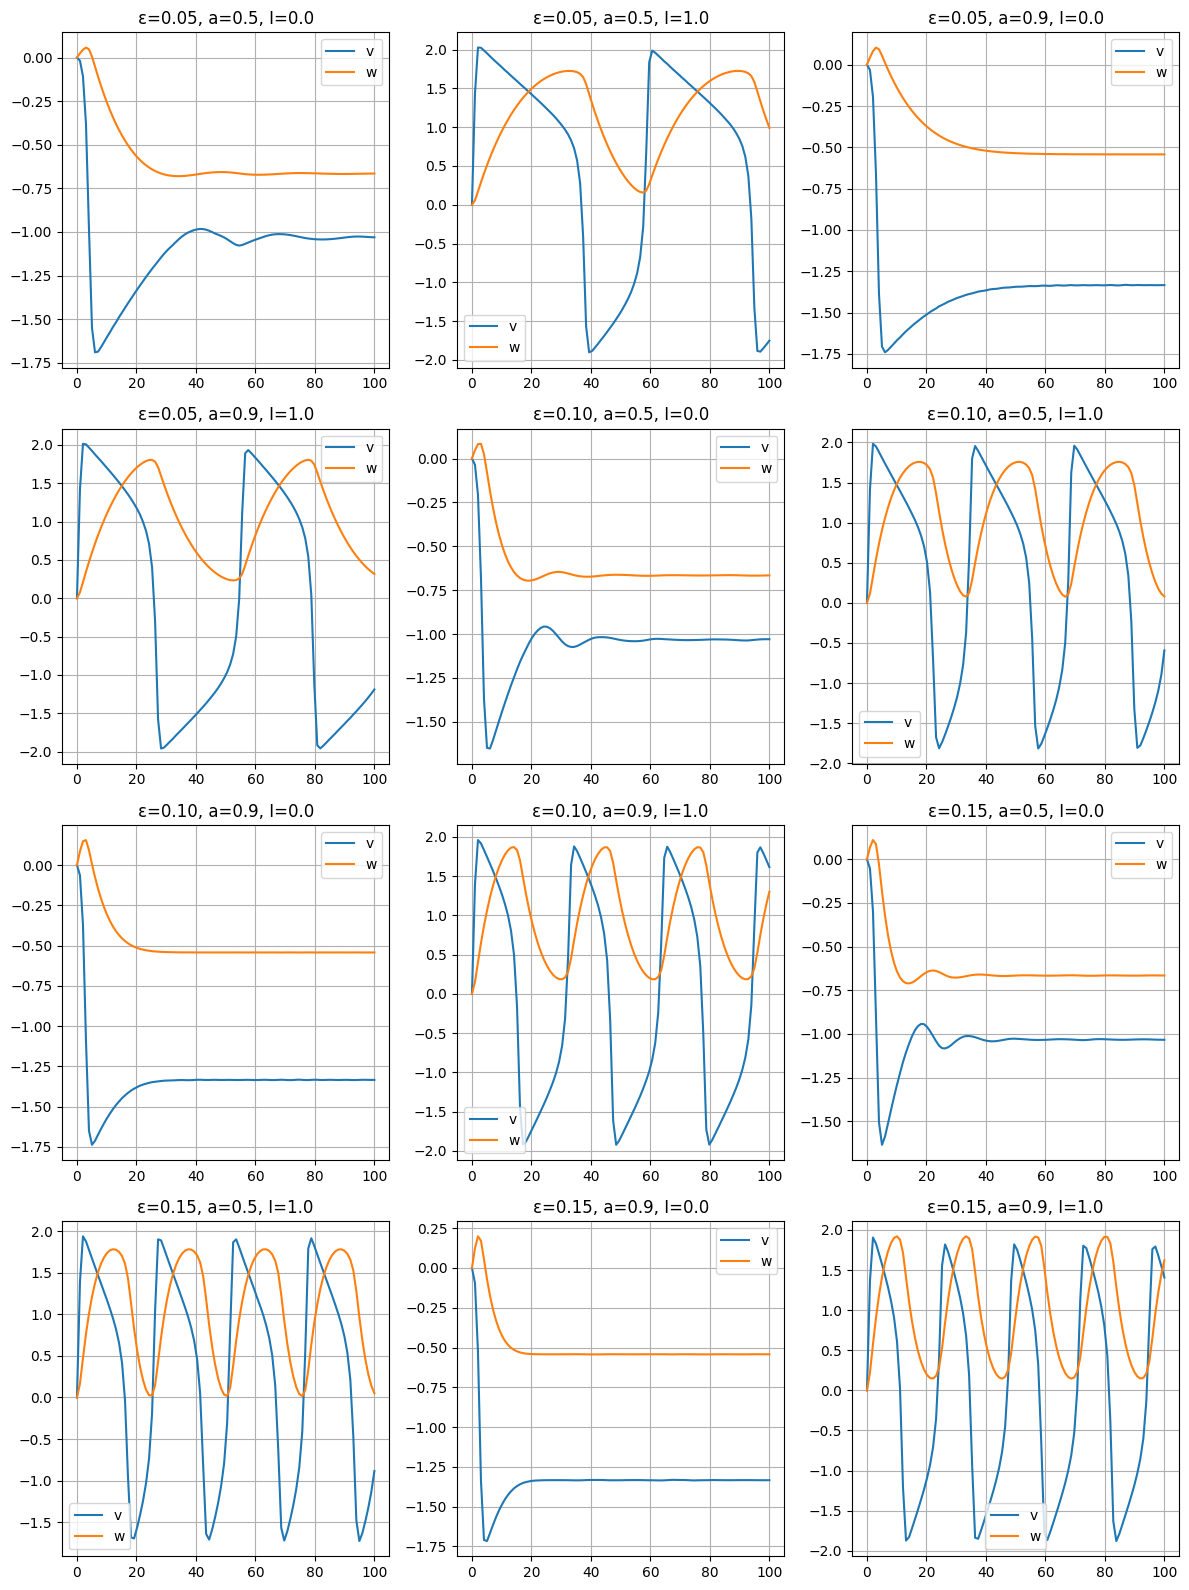

In [48]:
def solve_fhn(epsilon_range, a_range, I_range, b=0.8):
    solutions = []
    template = """dv/dt = v - v**3/3 - w + {},
                  dw/dt = {}*(v + {} - {}*w)"""
                  
    for epsilon in epsilon_range:
        for a in a_range:
            for I in I_range:
                system = template.format(I, epsilon, a, b)
                y0 = np.array([0.0, 0.0])
                t = np.linspace(0, 100, 100)
                
                solution = integrate_ode(y0, t, system)
                if solution is not None:
                    solutions.append({
                        'params': (epsilon, a, I),
                        'equations': system,
                        'solution': solution,
                        'time_points': t
                    })
    return solutions

if __name__ == "__main__":
    epsilon_range = np.linspace(0.05, 0.15, 3)
    a_range = np.linspace(0.5, 0.9, 2)
    I_range = np.linspace(0.0, 1.0, 2)
    
    solutions = solve_fhn(epsilon_range, a_range, I_range)
    
    with open('fitzhugh_nagumo.pkl', 'wb') as f:
        pickle.dump(solutions, f)
    
    with open('fitzhugh_nagumo.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        v = sol['solution'][:, 0]
        w = sol['solution'][:, 1]
        epsilon, a, I = sol['params']
        
        axes[idx].plot(t, v, label='v')
        axes[idx].plot(t, w, label='w')
        axes[idx].set_title(f'ε={epsilon:.2f}, a={a:.1f}, I={I:.1f}')
        axes[idx].grid(True)
        axes[idx].legend()
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

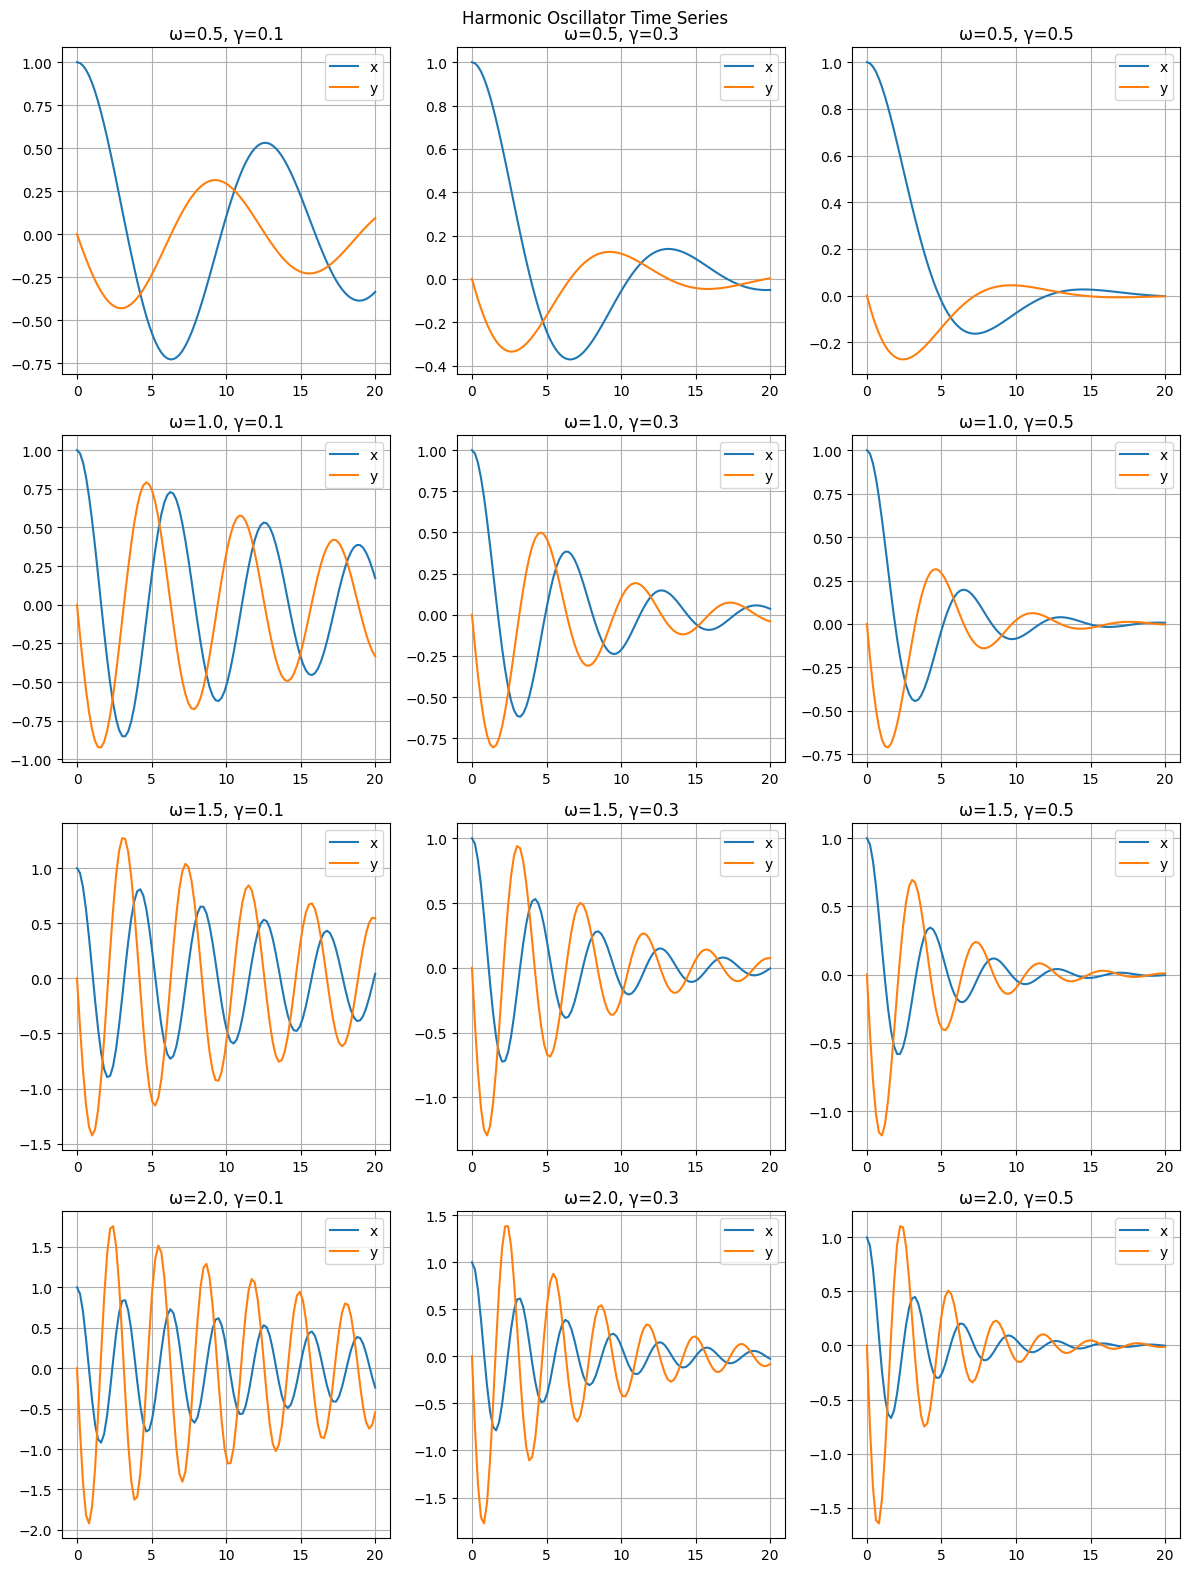

In [49]:
def solve_ho(omega_range, gamma_range, y0=np.array([1.0, 0.0]), t=np.linspace(0, 20, 100)):
    solutions = []
    template = "dx/dt = y, dy/dt = -{}*x - {}*y"
    for omega in omega_range:
        for gamma in gamma_range:
            system = template.format(omega**2, gamma)
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (omega, gamma),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

if __name__ == "__main__":
    omega_range = np.linspace(0.5, 2.0, 4)  # natural frequency
    gamma_range = np.linspace(0.1, 0.5, 3)  # damping
    
    solutions = solve_ho(omega_range, gamma_range)
    
    with open('harmonic_oscillator.pkl', 'wb') as f:
        pickle.dump(solutions, f)
        
    with open('harmonic_oscillator.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        x = sol['solution'][:, 0]
        y = sol['solution'][:, 1]
        omega, gamma = sol['params']
        axes[idx].plot(t, x, label='x')
        axes[idx].plot(t, y, label='y')
        axes[idx].set_title(f'ω={omega:.1f}, γ={gamma:.1f}')
        axes[idx].grid(True)
        axes[idx].legend()
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Harmonic Oscillator Time Series')
    plt.tight_layout()
    plt.show()

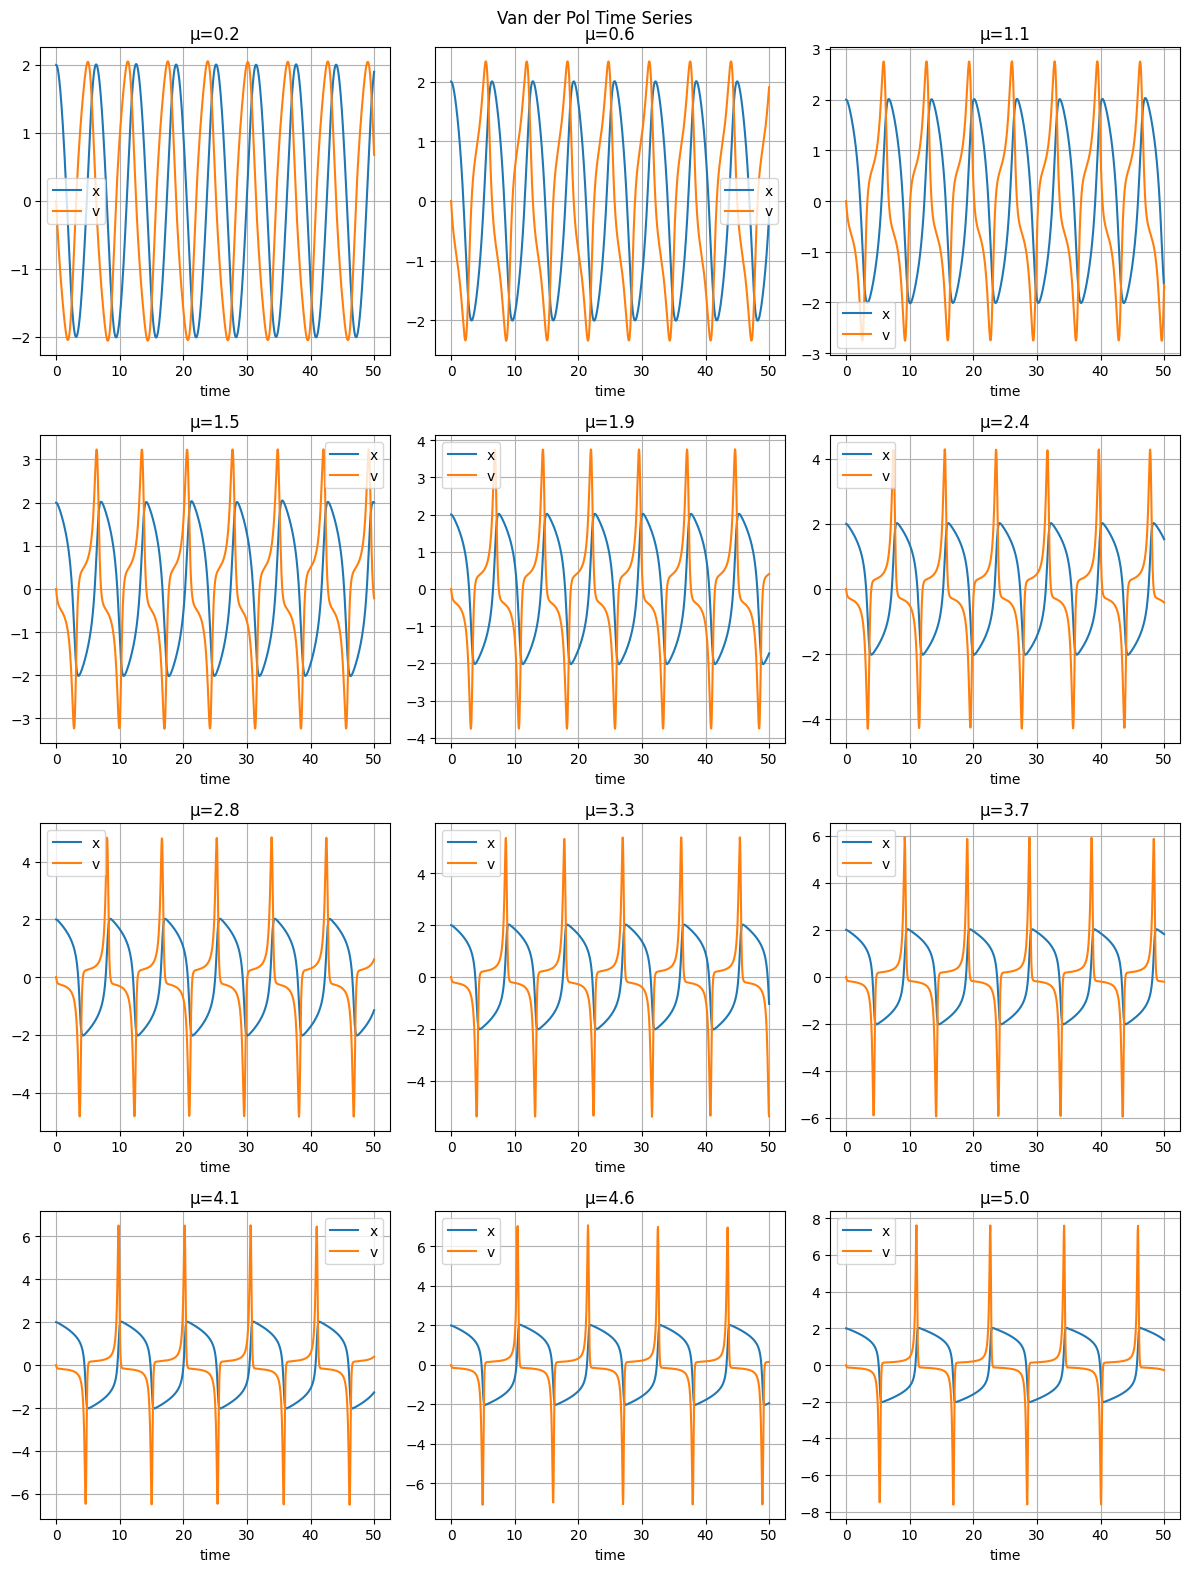

In [45]:
def solve_vdp(mu_range):
    solutions = []
    template = "dx/dt = y, dy/dt = {}*(1-x*x)*y - x"
                  
    for mu in mu_range:
        system = template.format(mu)
        y0 = np.array([2.0, 0.0])
        t = np.linspace(0, 50, 1000)
        
        solution = integrate_ode(y0, t, system)
        if solution is not None:
            solutions.append({
                'params': (mu,),
                'equations': system,
                'solution': solution,
                'time_points': t
            })
    return solutions

if __name__ == "__main__":
    mu_range = np.linspace(0.2, 5.0, 12)  # nonlinearity parameter
    
    solutions = solve_vdp(mu_range)
    
    with open('van_der_pol.pkl', 'wb') as f:
        pickle.dump(solutions, f)
    
    with open('van_der_pol.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        x = sol['solution'][:, 0]
        v = sol['solution'][:, 1]
        mu = sol['params'][0]
        
        axes[idx].plot(t, x, label='x')
        axes[idx].plot(t, v, label='v')
        axes[idx].set_title(f'μ={mu:.1f}')
        axes[idx].grid(True)
        axes[idx].legend()
        axes[idx].set_xlabel('time')
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Van der Pol Time Series')
    plt.tight_layout()
    plt.show()

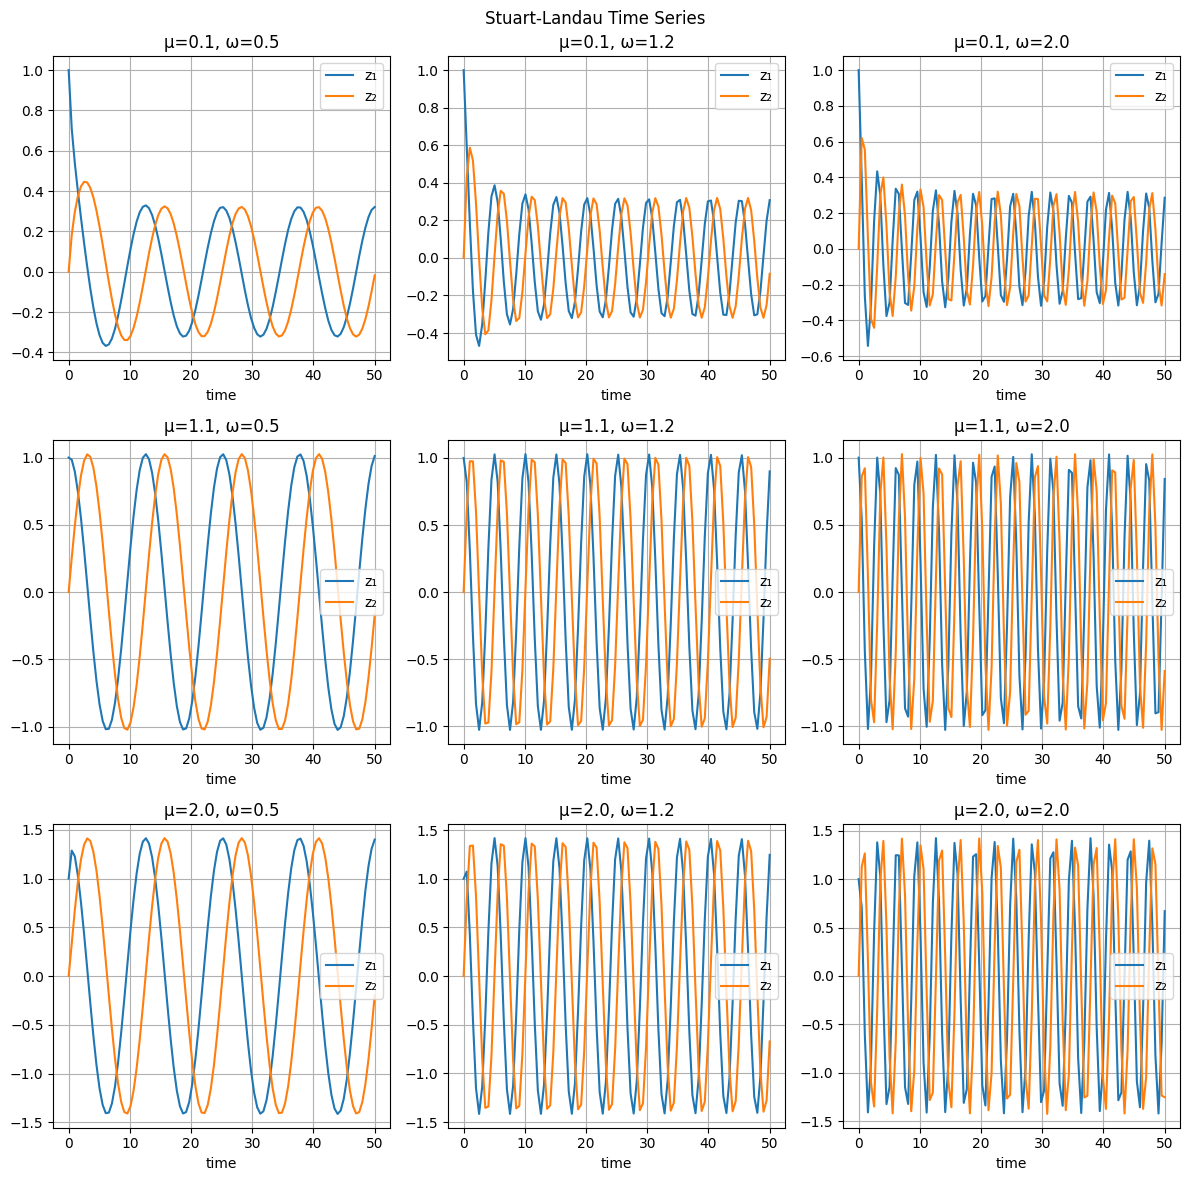

In [50]:
def solve_stuart_landau(mu_range, omega_range):
    solutions = []
    template = """dz1/dt = {}*z1 - {}*z2 - z1*(z1**2 + z2**2),
                  dz2/dt = {}*z1 + {}*z2 - z2*(z1**2 + z2**2)"""
    
    for mu in mu_range:
        for omega in omega_range:
            system = template.format(mu, omega, omega, mu)
            y0 = np.array([1.0, 0.0])
            t = np.linspace(0, 50, 100)
            
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (mu, omega),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

if __name__ == "__main__":
    mu_range = np.linspace(0.1, 2.0, 3)
    omega_range = np.linspace(0.5, 2.0, 3)
    
    solutions = solve_stuart_landau(mu_range, omega_range)
    with open('stuart_landau.pkl', 'wb') as f:
        pickle.dump(solutions, f)
    
    with open('stuart_landau.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        z1 = sol['solution'][:, 0]
        z2 = sol['solution'][:, 1]
        mu, omega = sol['params']
        
        axes[idx].plot(t, z1, label='z₁')
        axes[idx].plot(t, z2, label='z₂')
        axes[idx].set_title(f'μ={mu:.1f}, ω={omega:.1f}')
        axes[idx].grid(True)
        axes[idx].legend()
        axes[idx].set_xlabel('time')
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Stuart-Landau Time Series')
    plt.tight_layout()
    plt.show()

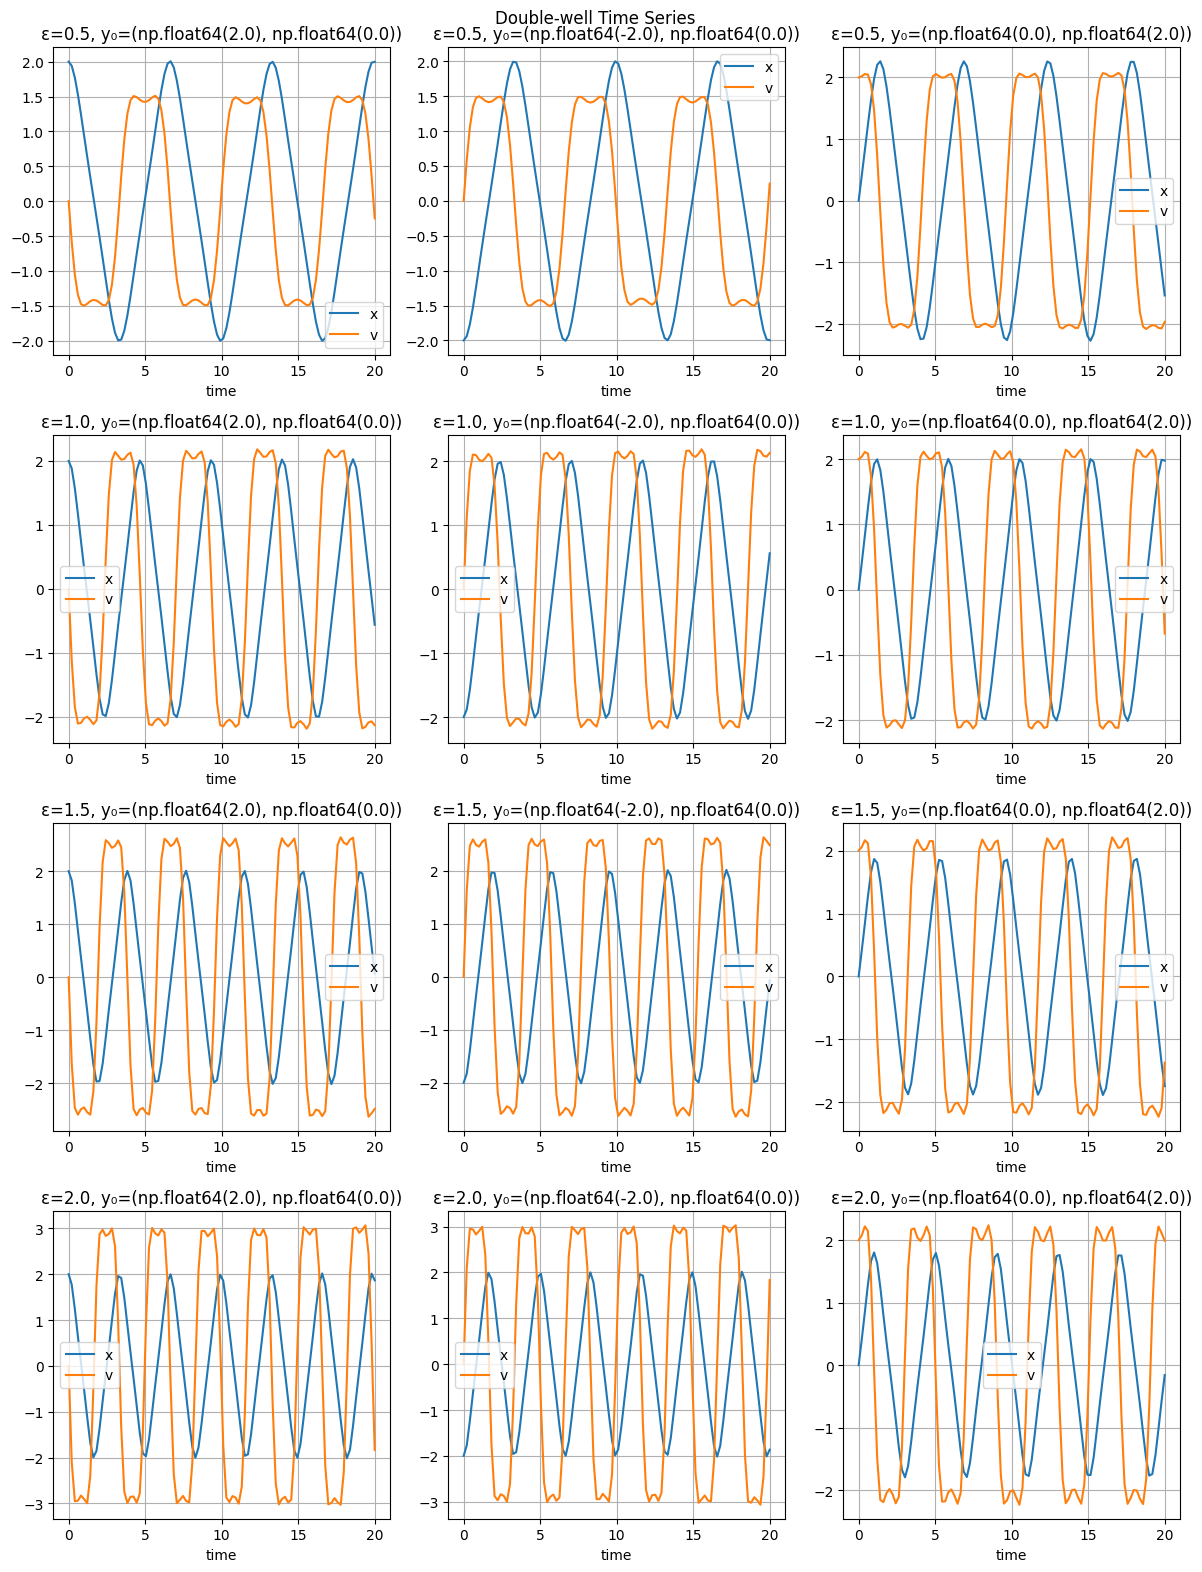

In [51]:
def solve_double_well(epsilon_range):
    solutions = []
    template = """dx/dt = y,
                  dy/dt = {}*(x - x**3)"""
    
    for epsilon in epsilon_range:
        system = template.format(epsilon)
        
        initial_conditions = [
            np.array([2.0, 0.0]),
            np.array([-2.0, 0.0]),
            np.array([0.0, 2.0])
        ]
        
        t = np.linspace(0, 20, 100)
        
        for y0 in initial_conditions:
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (epsilon, tuple(y0)),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

if __name__ == "__main__":
    epsilon_range = np.linspace(0.5, 2.0, 4)
    
    solutions = solve_double_well(epsilon_range)
    with open('double_well.pkl', 'wb') as f:
        pickle.dump(solutions, f)
    
    with open('double_well.pkl', 'rb') as f:
        solutions = pickle.load(f)
    
    n = len(solutions)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    
    for idx, sol in enumerate(solutions):
        t = sol['time_points']
        x = sol['solution'][:, 0]
        v = sol['solution'][:, 1]
        epsilon, y0 = sol['params']
        
        axes[idx].plot(t, x, label='x')
        axes[idx].plot(t, v, label='v')
        axes[idx].set_title(f'ε={epsilon:.1f}, y₀={y0}')
        axes[idx].grid(True)
        axes[idx].legend()
        axes[idx].set_xlabel('time')
    
    for idx in range(len(solutions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Double-well Time Series')
    plt.tight_layout()
    plt.show()